In [7]:
import numpy as np
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt

In [12]:
label_path = './input/labels.csv'
image_path = './input/head_ct/head_ct'

label_df = pd.read_csv(label_path)
image_files = sorted(glob.glob(image_path + '/*.png'))

In [13]:
labels = np.array(label_df[' hemorrhage'].tolist())
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [291]:
images = np.array([cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in image_files])

/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


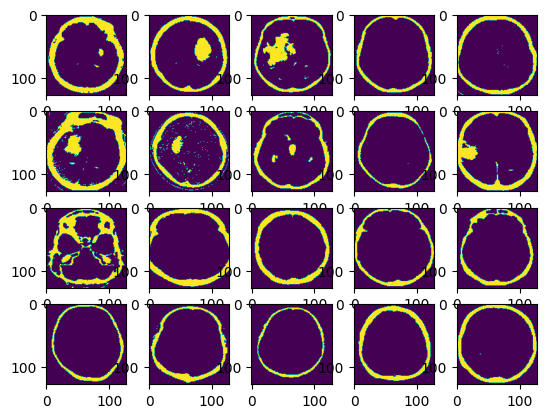

In [24]:
def preprocess(img_index, thre=180):
    imgs = []
    for i in img_index:
        imgs.append(cv2.imread(image_files[i]))

    res = []
    for img in imgs:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_norm = cv2.normalize(img_gray, img_gray, 0, 255, cv2.NORM_MINMAX)
        _, img_binary = cv2.threshold(img_norm, thre, 1, cv2.THRESH_BINARY)
        imgn = cv2.erode(img_binary, np.ones((3, 3), np.uint8), iterations=1)
        img_resp = cv2.resize(imgn, (128, 128))
        res.append(img_resp)
    return res


preview = preprocess(np.random.randint(0, 100, 10))
for i in range(0, 10):
    plt.subplot(4, 5, i + 1)
    plt.imshow(preview[i])

preview = preprocess(np.random.randint(100, 200, 10))
for i in range(10, 20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(preview[i - 10])

In [10]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

In [64]:
images = preprocess(range(0, 200))
images = [img.flatten() for img in images]
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3)

In [66]:
kfold = KFold(n_splits=10)
model = KNeighborsClassifier(n_neighbors=4)
result = cross_val_score(model, X_train, y_train, cv=kfold)
print(result)

[0.5        0.42857143 0.57142857 0.35714286 0.57142857 0.57142857
 0.71428571 0.57142857 0.64285714 0.64285714]


In [113]:
cv_score = []
for para in range(100, 250):
    images = preprocess(range(0, 200), para)
    images = [img.flatten() for img in images]
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3)
    kfold = KFold(n_splits=5, shuffle=True)
    model = KNeighborsClassifier(n_neighbors=4)
    result = cross_val_score(model, X_train, y_train, cv=kfold)
    cv_score.append(result.mean())
    print(para)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


197.35


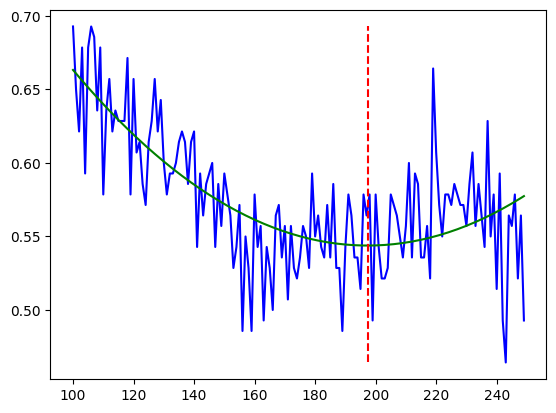

In [114]:
x = range(100, 250)
y = cv_score
coef = np.polyfit(x, y, 2)
y_fit = np.polyval(coef, x)
plt.plot(x, y, 'b')
plt.plot(x, y_fit, 'g')
# 找出其中的峰值/对称点
if coef[0] != 0:
    x0 = -0.5 * coef[1] / coef[0]
    x0 = round(x0, 2)
    plt.plot([x0] * 5, np.linspace(min(y), max(y), 5), 'r--')
    print(x0)

In [115]:
images = preprocess(range(0, 200), 197)
img_flatten = [img.flatten() for img in images]
X_train, X_test, y_train, y_test = train_test_split(img_flatten, labels, test_size=0.3)

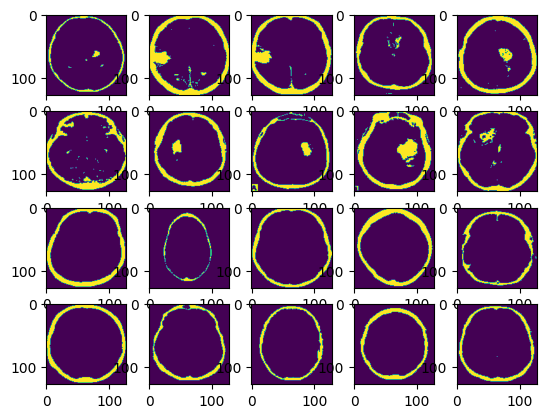

In [116]:
for i in range(0, 10):
    preview = images[np.random.randint(0, 100)]
    plt.subplot(4, 5, i + 1)
    plt.imshow(preview)

for i in range(10, 20):
    preview = images[np.random.randint(100, 200)]
    plt.subplot(4, 5, i + 1)
    plt.imshow(preview)

Text(0, 0.5, 'Accuracy')

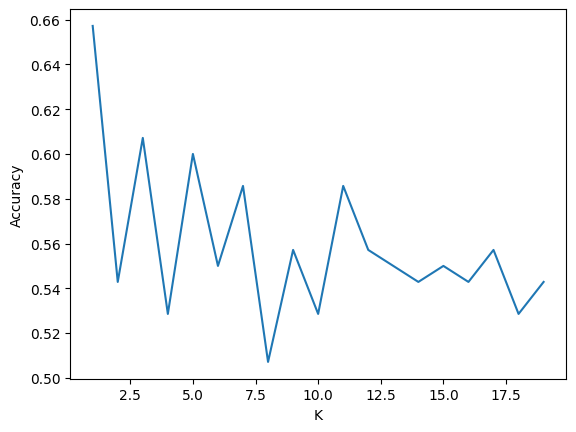

In [204]:
kfold = KFold(n_splits=5)
k_range = range(1, 20)
cv_scores = []
for n in k_range:
    knn = KNeighborsClassifier(n)
    scores = cross_val_score(knn, X_train, y_train, cv=kfold)
    cv_scores.append(scores.mean())
plt.plot(k_range, cv_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')

In [156]:
svm_model = svm.SVC(probability=True)
scores = cross_val_score(svm_model, X_train, y_train, cv=kfold)
print(scores)

[0.67857143 0.67857143 0.71428571 0.78571429 0.67857143]


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, Activation,GlobalAveragePooling2D, \
    GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
import math

2023-05-27 12:12:33.445801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 12:12:45.750826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-11.6/lib64
2023-05-27 12:12:45.751906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-11.6/lib64
2023-05-27 12:12:45.

In [163]:
train_image_data = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)
validation_image_data = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=90,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0)

In [28]:
def simple_conv_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1, activation='sigmoid'))
    return model

In [29]:
model = simple_conv_model((128, 128, 1))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 32)          9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 32)        

In [14]:
files = sorted(glob.glob('./input/head_ct/head_ct/*.png'))
images = np.array([cv2.imread(path) for path in files])
images = np.array([cv2.resize(image, (128, 128)) for image in images])

/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [31]:
images = np.array(preprocess(range(0, 200)))

In [32]:
trainX, test_X, trainY, test_Y = train_test_split(images, labels, test_size=0.2)
trainX.shape, test_X.shape, trainY.shape, test_Y.shape

((160, 128, 128), (40, 128, 128), (160,), (40,))

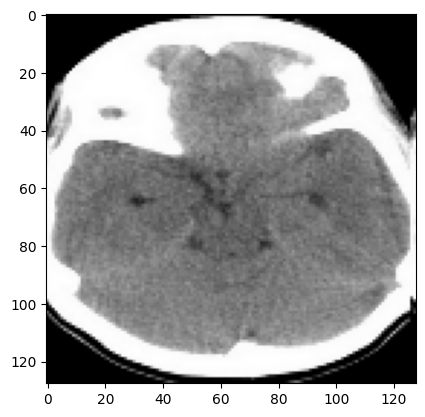

In [16]:
plt.imshow(trainX[9])

In [416]:
!nvidia-smi

Fri May 26 06:21:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0 Off |                  Off |
|  0%   55C    P2   115W / 450W |   8074MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [456]:
model = Sequential([
    Dense(32, input_dim=16384),  # 输入值784(28*28) => 输出值32
    Activation('relu'),        # 激励函数 转换成非线性数据
    Dense(2),                 # 输出为10个单位的结果
    Activation('softmax')      # 激励函数 调用softmax进行分类
])

In [454]:
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) #学习率lr

model.compile(
    optimizer = rmsprop,                 # 加速神经网络
    loss = 'categorical_crossentropy',   # 损失函数
    metrics = ['accuracy'],               # 计算误差或准确率
)

/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [27]:
hist = model.fit(trainX, trainY,
                 steps_per_epoch=64,
                 shuffle=True,
                 epochs=50,
                 validation_split=0.2,
                 callbacks=[ModelCheckpoint("weights.h5", monitor='val_accuracy', save_best_only=True, mode='max')])

Epoch 1/50


ValueError: in user code:

    File "/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ubuntu/miniconda3/envs/env/lib/python3.7/site-packages/keras/engine/input_spec.py", line 278, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "conv2d_3" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (2, 128, 128, 3)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(2, 128, 128, 3), dtype=uint8)
      • training=True
      • mask=None


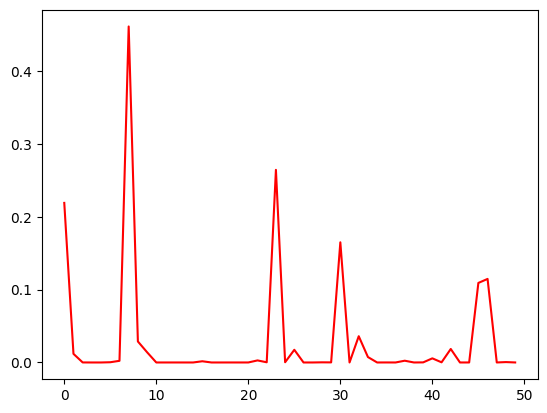

In [22]:
plt.plot(hist.history["loss"], 'r')

In [419]:
model.load_weights("weights.h5")

In [436]:
def check_accuracy(model, setX, actual, print_images=True):
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)])
    if print_images:
        rows = math.ceil(len(predicted) / 10.)
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)):
            plt.subplot(rows, 10, i + 1)
            plt.imshow(setX[i])
            plt.title("pred " + str(predicted[i]) + " actual " + str(actual[i]))

    confusion = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion.ravel()
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted == actual) / len(predicted) * 100., "%")
    return (tn, fp, fn, tp)

In [437]:
check_accuracy(model, test_X / 255., test_Y, False)

2/2 [==============================] - 0s 214ms/step
True positive: 19 , True negative: 0 , False positive: 21 , False negative: 0
Total accuracy: 47.5 %


(0, 21, 0, 19)

In [158]:
best_knn = KNeighborsClassifier(n_neighbors=3)
best_knn.fit(X_train, y_train)
print(best_knn.score(X_train, y_train))

knn_y_pred = best_knn.predict_proba(X_test)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_y_pred)
knn_auc = auc(knn_fpr, knn_tpr)

svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict_proba(X_test)[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_pred)
svm_auc = auc(svm_fpr, svm_tpr)

0.8285714285714286


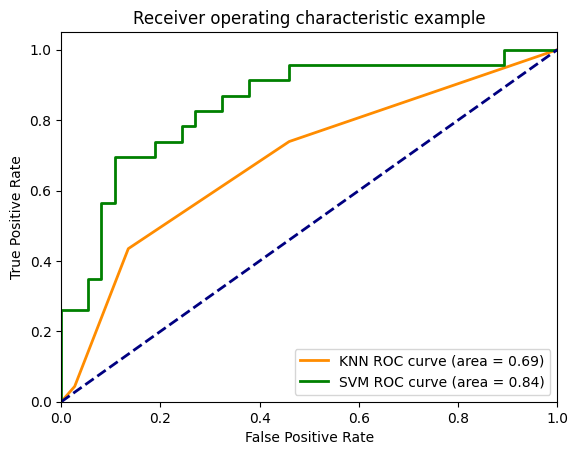

KNN Confusion Matrix: 
 [[32  5]
 [13 10]]
SVM Confusion Matrix: 
 [[20 17]
 [ 2 21]]


In [161]:
plt.figure()
plt.plot(knn_fpr, knn_tpr, color='darkorange', lw=2, label='KNN ROC curve (area = %0.2f)' % knn_auc)
plt.plot(svm_fpr, svm_tpr, color='green', lw=2, label='SVM ROC curve (area = %0.2f)' % svm_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()  # 混淆矩阵
knn_pred = best_knn.predict(X_test)
svm_pred = svm_model.predict(X_test)
print("KNN Confusion Matrix: \n", confusion_matrix(y_test, knn_pred))
print("SVM Confusion Matrix: \n", confusion_matrix(y_test, svm_pred))